# Vegans, vegetarians, fish-eaters and meat-eaters in the UK show discrepant environmental impacts

Tools: Python, Pandas, Matplotlib, Seaborn, Plotly

In [4]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px

### Build Tree Map

1. Top-level grouping: We chose dietary groups as the top-level grouping because these can have significant influences on environmental indicators. This top layer categorizes the population based on their eating habits, such as vegetarian, meat-based diets, etc.
2. Secondary level of grouping: Within each dietary group, we further divided the data by gender. This secondary layer helps us understand if there are notable differences in environmental impacts between males and females within the same dietary category.
3. Finest level of grouping: Finally, within each gender category, we further segmented the data by age groups. This allows us to observe potential differences in environmental impacts among different age ranges within the same gender and dietary group.

In [5]:
# Read data
df = pd.read_csv('Results_21Mar2022.csv')

df.head()

,mc_run_id,grouping,mean_ghgs,mean_land,mean_watscar,mean_eut,mean_ghgs_ch4,mean_ghgs_n2o,mean_bio,mean_watuse,...,sd_eut,sd_ghgs_ch4,sd_ghgs_n2o,sd_bio,sd_watuse,sd_acid,n_participants,sex,diet_group,age_group
0,1,fish_female_20-29,5.421821,8.612772,14165.86240,23.945372,1.164643,0.343663,476.270413,679.923479,...,8.167013,0.632547,0.146827,283.883428,249.472563,8.231176,1329,female,fish,20-29
1,1,fish_female_30-39,5.436673,8.680248,15222.77063,24.305262,1.154118,0.326868,467.923201,709.343785,...,8.467858,0.601941,0.130298,270.247108,277.927269,7.947014,2024,female,fish,30-39
2,1,fish_female_40-49,5.289333,8.467723,15818.80068,24.191105,1.108404,0.310324,438.659832,707.925368,...,8.107006,0.572941,0.119872,252.415063,275.760515,8.103589,1689,female,fish,40-49
3,1,fish_female_50-59,5.169020,8.219199,16962.06009,24.748154,1.032501,0.298130,395.787622,720.825105,...,9.514028,0.509689,0.104731,209.566722,310.422445,8.712428,946,female,fish,50-59
4,1,fish_female_60-69,5.380268,8.570718,18212.66232,25.559430,1.098828,0.310735,421.176867,749.392826,...,9.258068,0.609398,0.113401,264.599257,315.922570,8.616601,492,female,fish,60-69


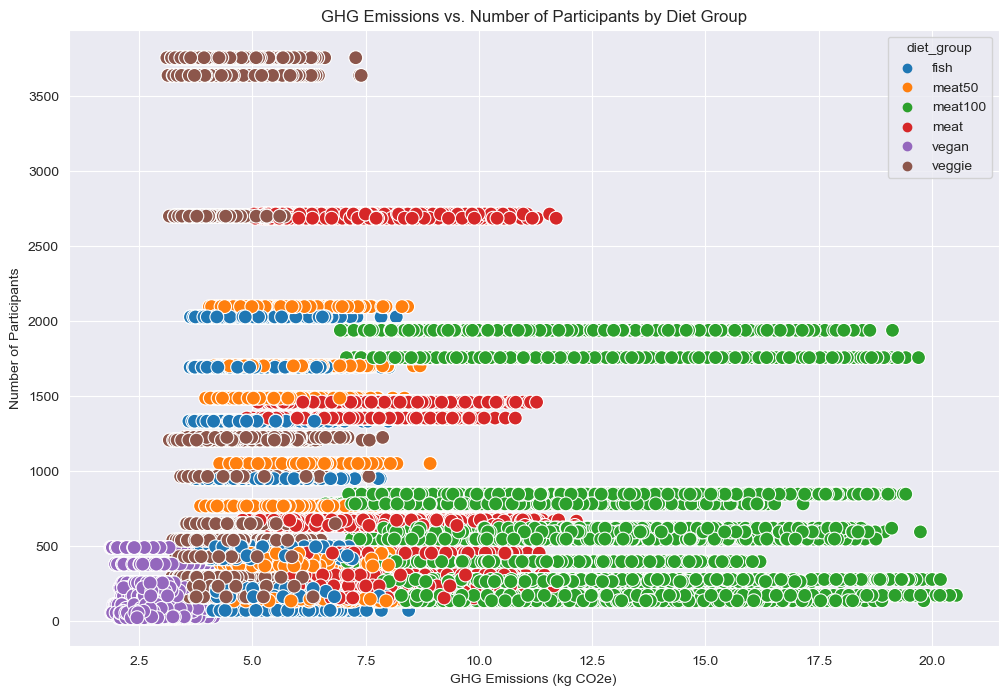

In [28]:
# Using scatter to indicate the outliers
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='mean_ghgs', y='n_participants', hue='diet_group', s=100)
plt.title('GHG Emissions vs. Number of Participants by Diet Group')
plt.xlabel('GHG Emissions (kg CO2e)')
plt.ylabel('Number of Participants')
plt.show()


In [6]:
# Check the columns
df.columns

Index(['mc_run_id', 'grouping', 'mean_ghgs', 'mean_land', 'mean_watscar',
       'mean_eut', 'mean_ghgs_ch4', 'mean_ghgs_n2o', 'mean_bio', 'mean_watuse',
       'mean_acid', 'sd_ghgs', 'sd_land', 'sd_watscar', 'sd_eut',
       'sd_ghgs_ch4', 'sd_ghgs_n2o', 'sd_bio', 'sd_watuse', 'sd_acid',
       'n_participants', 'sex', 'diet_group', 'age_group'],
      dtype='object')

In [11]:
# Group by dietary
grouped_data = df.groupby(['diet_group', 'sex', 'age_group']).agg({
    'mean_ghgs': 'sum',  # 按组求 mean_ghgs 的总和
    'n_participants': 'sum'  # 同时聚合参与者数量
}).reset_index()

# Write the grouped data to a new CSV file
grouped_data.to_csv('grouped_data.csv', index=False)
print(grouped_data.head())

  diet_group     sex age_group    mean_ghgs  n_participants
0       fish  female     20-29  4902.947125         1329000
1       fish  female     30-39  4942.664484         2024000
2       fish  female     40-49  4927.040173         1689000
3       fish  female     50-59  4944.320334          946000
4       fish  female     60-69  5103.822519          492000


In [13]:
# 添加标签和悬停文本
grouped_data['label'] = grouped_data['diet_group'] + ', ' + grouped_data['sex'] + ', ' + grouped_data['age_group']
grouped_data['hover_text'] = grouped_data['label'] + '<br>Total GHG Emissions: ' + grouped_data['mean_ghgs'].astype(str) + \
                             '<br>Number of Participants: ' + grouped_data['n_participants'].astype(str)

# 使用 Plotly Express 创建 TreeMap
fig = px.treemap(grouped_data,
                 path=['diet_group', 'sex', 'age_group'],
                 values='mean_ghgs',
                 color='mean_ghgs',
                 color_continuous_scale='Blues',
                 title='TreeMap of GHG Emissions by Diet Group, Sex, and Age Group',
                 custom_data=['hover_text'],
                 labels={'mean_ghgs': 'GHG Emissions'},
                 height=600,  # 调整图表高度
                 width=800)   # 调整图表宽度

# 更新图形布局和悬停信息
fig.update_traces(hovertemplate='%{customdata[0]}')
fig.update_layout(coloraxis_colorbar=dict(
    title="GHG Emissions",
    tickvals=[grouped_data['mean_ghgs'].min(), grouped_data['mean_ghgs'].max()],
    ticktext=['Low', 'High']
))

# 显示图形
fig.show()

In [30]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
import webbrowser
from threading import Timer

# Define the function to open a browser
def open_browser():
    webbrowser.open_new("http://127.0.0.1:8050/")

# Group data and aggregate various environmental indicators and participant count
grouped_data = df.groupby(['diet_group', 'sex', 'age_group']).agg({
    'mean_ghgs': 'sum',
    'mean_ghgs_ch4': 'sum',
    'mean_ghgs_n2o': 'sum',
    'mean_land': 'sum',
    'mean_watscar': 'sum',
    'mean_eut': 'sum',
    'mean_bio': 'sum',
    'mean_watuse': 'sum',
    'mean_acid': 'sum',
    'n_participants': 'sum'
}).reset_index()

# Initialize Dash application
app = dash.Dash(__name__)

# Define color gradient mappings and human-readable labels
indicators = {
    'mean_ghgs': 'Greenhouse Gas Emissions',
    'mean_ghgs_ch4': 'Methane Emissions',
    'mean_ghgs_n2o': 'Nitrous Oxide Emissions',
    'mean_land': 'Land Use',
    'mean_watscar': 'Water Scarcity',
    'mean_eut': 'Eutrophication',
    'mean_bio': 'Biodiversity',
    'mean_watuse': 'Water Use',
    'mean_acid': 'Acidification Potential'
}

color_scales = {
    'mean_ghgs': 'Viridis', 'mean_ghgs_ch4': 'Cividis',
    'mean_ghgs_n2o': 'Plasma', 'mean_land': 'Magma',
    'mean_watscar': 'Turbo', 'mean_eut': 'Temps',
    'mean_bio': 'Earth', 'mean_watuse': 'Deep', 'mean_acid': 'Gray'
}

# Set up Dash application layout
app.layout = html.Div([
    html.H1("Comparing Environmental Impacts of Different Diets", style={'textAlign': 'center', 'color': 'black'}),
    dcc.Dropdown(
        id='indicator-selector',
        options=[{'label': indicators[k], 'value': k} for k in indicators],
        value='mean_ghgs',
        style={'width': '50%', 'margin': 'auto'}
    ),
    dcc.Graph(id='treemap', style={'height': '42vw', 'width': '67.2vw', 'margin': 'auto'})  # Adjusted to 70% of original size
])

# Callback function to update the graph
@app.callback(
    Output('treemap', 'figure'),
    [Input('indicator-selector', 'value')]
)
def update_treemap(selected_indicator):
    fig_number = list(indicators.keys()).index(selected_indicator) + 1
    title = f"Figure {fig_number}: {indicators[selected_indicator]} by Diet Group, Sex, and Age Group"
    fig = px.treemap(
        grouped_data,
        path=['diet_group', 'sex', 'age_group'],
        values=selected_indicator,
        color=selected_indicator,
        color_continuous_scale=color_scales[selected_indicator],
        title=title,
        labels={'value': 'Sum Value'}
    )
    # Set layout with enhanced visual settings including color bar adjustments
    fig.update_layout(
        paper_bgcolor='white',
        plot_bgcolor='white',
        title_font_color='black',
        transition_duration=500,
        coloraxis_colorbar=dict(
            title="Impact Level",
            title_font_color='black',  # Set title font color of the color bar
            tickfont_color='black'     # Set tick font color of the color bar
        )
    )
    fig.update_traces(marker=dict(line=dict(width=3, color='white')))
    return fig

# Open the browser window to the Dash app
Timer(1, open_browser).start()

# Run the Dash application
if __name__ == '__main__':
    app.run_server(debug=True)


In [33]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
import webbrowser
from threading import Timer

# Define the function to open a browser
def open_browser():
    webbrowser.open_new("http://127.0.0.1:8050/")

# Group data and aggregate various environmental indicators and participant count
grouped_data = df.groupby(['diet_group', 'sex', 'age_group']).agg({
    'mean_ghgs': 'sum',
    'mean_ghgs_ch4': 'sum',
    'mean_ghgs_n2o': 'sum',
    'mean_land': 'sum',
    'mean_watscar': 'sum',
    'mean_eut': 'sum',
    'mean_bio': 'sum',
    'mean_watuse': 'sum',
    'mean_acid': 'sum',
    'n_participants': 'sum'
}).reset_index()

# Initialize Dash application
app = dash.Dash(__name__)

# Define color gradient mappings and human-readable labels
indicators = {
    'mean_ghgs': 'Greenhouse Gas Emissions',
    'mean_ghgs_ch4': 'Methane Emissions',
    'mean_ghgs_n2o': 'Nitrous Oxide Emissions',
    'mean_land': 'Land Use',
    'mean_watscar': 'Water Scarcity',
    'mean_eut': 'Eutrophication',
    'mean_bio': 'Biodiversity',
    'mean_watuse': 'Water Use',
    'mean_acid': 'Acidification Potential'
}

color_scales = {
    'mean_ghgs': 'Viridis', 'mean_ghgs_ch4': 'Cividis',
    'mean_ghgs_n2o': 'Plasma', 'mean_land': 'Magma',
    'mean_watscar': 'Turbo', 'mean_eut': 'Temps',
    'mean_bio': 'Earth', 'mean_watuse': 'Deep', 'mean_acid': 'Gray'
}

# Set up Dash application layout
app.layout = html.Div([
    html.H1("Comparing Environmental Impacts of Different Diets", style={'textAlign': 'center', 'color': 'black'}),
    dcc.Dropdown(
        id='indicator-selector',
        options=[{'label': indicators[k], 'value': k} for k in indicators],
        value='mean_ghgs',
        style={'width': '50%', 'margin': 'auto'}
    ),
    dcc.Graph(id='treemap', style={'height': '42vw', 'width': '67.2vw', 'margin': 'auto'})  # Adjusted to 70% of original size
])

# Callback function to update the graph
@app.callback(
    Output('treemap', 'figure'),
    [Input('indicator-selector', 'value')]
)
def update_treemap(selected_indicator):
    fig_number = list(indicators.keys()).index(selected_indicator) + 1
    title = f"Figure {fig_number}: {indicators[selected_indicator]} by Diet Group, Sex, and Age Group"

    # Calculate the size based on the selected indicator (total sum or average)
    if selected_indicator in ['mean_ghgs', 'mean_ghgs_ch4', 'mean_ghgs_n2o', 'mean_land', 'mean_watscar', 'mean_eut', 'mean_bio', 'mean_watuse', 'mean_acid']:
        sizes = grouped_data[selected_indicator]  # Use the total sum
    else:
        sizes = grouped_data[selected_indicator] / grouped_data['n_participants']  # Use the average

    fig = px.treemap(
        grouped_data,
        path=['diet_group', 'sex', 'age_group'],
        values=sizes,
        color=selected_indicator,
        color_continuous_scale=color_scales[selected_indicator],
        title=title,
        labels={'value': 'Sum Value'}
    )
    # Set layout with enhanced visual settings including color bar adjustments
    fig.update_layout(
        paper_bgcolor='white',
        plot_bgcolor='white',
        title_font_color='black',
        transition_duration=500,
        coloraxis_colorbar=dict(
            title="Impact Level",
            title_font_color='black',  # Set title font color of the color bar
            tickfont_color='black'     # Set tick font color of the color bar
        )
    )
    fig.update_traces(marker=dict(line=dict(width=3, color='white')))
    return fig

# Open the browser window to the Dash app
Timer(1, open_browser).start()

# Run the Dash application
if __name__ == '__main__':
    app.run_server(debug=True)
